# Heston model parameter estimates using NMLE and CEKF

## Theory (Paolo)

## Algorithms

Once settled the theory behind the process we began to code our algorithm to test his quality with the following steps:

* __Simulate__ some data to create a dataset with known Stock and Volatility values
* __Test__ our algorithm against the simulated dataset to ensure his quality and possibly choose a set of practical initialization values
* __Apply__ the algorithm against s&p500 as a final test

### Data Simulation

To test the quality of our parameter estimation algorithm we've decided to test it against some simulated data. This task was not as easy as we thought and came with a bunch of issues we will see in the following slides

#### First attempt

As a first attempt we started from the discrete __SSM (State Space Model)__ of the __Heston Model__

\begin{equation}
    \begin{cases}
        V_k = V_{k-1} + \kappa (\theta - V_{k-1}) \delta + \sigma \sqrt{V_{k-1}} \Delta {W_v}_k \\
        z_k = \left( r- \frac{1}{2} V_{k} \right) \delta + \sqrt{(1-\rho^2) V_{k}} \Delta W_{sk} + \rho \Delta W_{vk}
    \end{cases} \label{26}
\end{equation}

where $W_{vk}$ and $W_{sk}$ are indipendent __Brownian Motions__ and

$$ S_{k} = S_{k-1}e^{z_k} $$

This approach was not feasible since negaivity of volatilities was not taken into account, therefore it was immeadiately discarded

#### Second attempt

To solve the negativity of volatilities we've tried two different approaches. In the first one we opted for a discretization with based on an NMLE method.

\begin{equation}
    \begin{cases}
        \sqrt{\tilde{V}_k} = \sqrt{\tilde{V}_{k-1}} + \frac{1}{2\sqrt{max(\tilde{V}_{k-1},\nu)}}\left[\kappa\theta -\kappa V_{k-1} - \frac{1}{4}\sigma^2\right] \delta + \frac{1}{2}\sigma\sqrt{\delta}\varepsilon_2 \\
        \sqrt{V_k} = \sqrt{\tilde{V}_k^+}
    \end{cases}
\end{equation}

This attempt solved the negativity of the volatility, altough it didn't behaved well on the long run, in addition to that we weren't able to assess his quality so we've decided to stick with the second option

Text(0.5, 1.0, 'V')

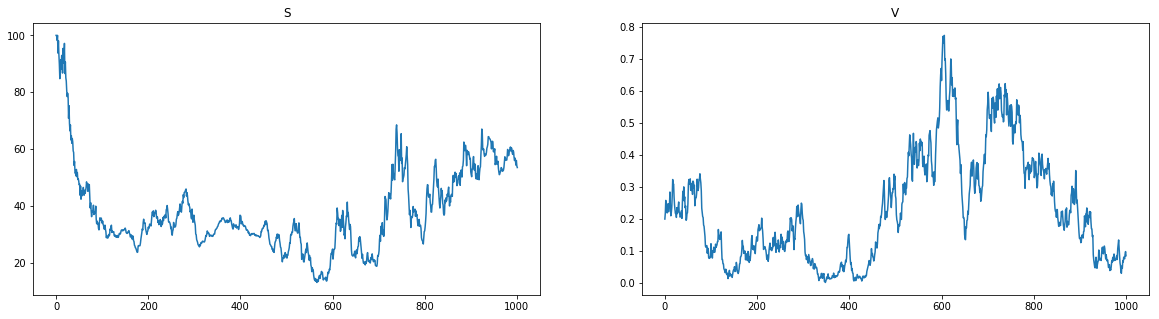

In [2]:
import matplotlib.pyplot as plt
import state_space_simulation as sss

n = 1000
param = {"r": 0.005, "k": 1, "theta": 0.25, "sigma": 0.5, "delta": 0.01, "rho": 0.001}
S, z, V = sss.generate_stock_data(n, param, "nmle")
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(S); axes[0].set_title('S'); axes[1].plot(V); axes[1].set_title('V')

#### Third attempt

In this last attempt we used the __full truncation__ scheme which proposes a so called __"discretization with smallest bias"__

__full trunctation__ is proposed as

\begin{equation}
    \begin{cases}
        \tilde{V}_k = \tilde{V}_{k-1} + \kappa (\theta - \tilde{V}^+_{k-1})\delta + \sigma \sqrt{\tilde{V}_{k-1}^+}\sqrt{\delta}\varepsilon_2 \\
        V_k = \tilde{V}_k^+
    \end{cases}
\end{equation}
\begin{equation}
    z_k = \left( r - \frac{1}{2} V_k \right)\delta + \sqrt{(1-\rho^2)V_k}\sqrt{\delta}\varepsilon_1 + \rho \sqrt{V_k}\sqrt{\delta}\varepsilon_2
\end{equation}

where $\tilde{V}_k^+ = max(V_k,0)$ and $\varepsilon\sim N(0,1)$

This solution appeared to be the one with the best behaviour so we've decided to stick with it

Text(0.5, 1.0, 'V')

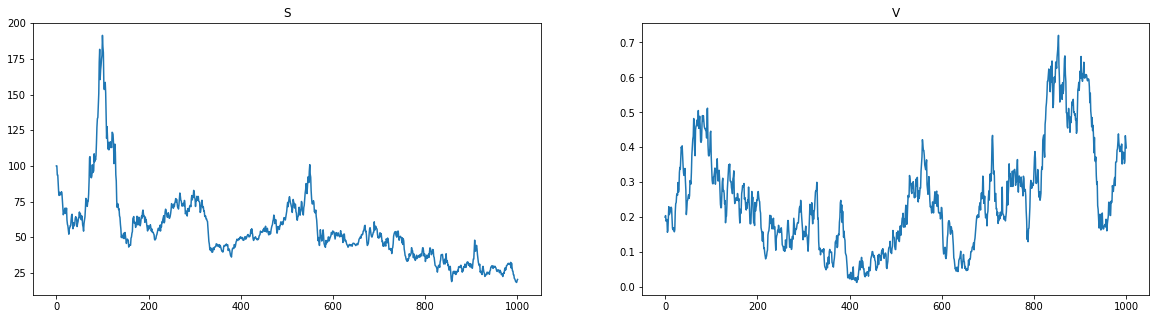

In [3]:
import matplotlib.pyplot as plt
import state_space_simulation as sss

n = 1000
param = {"r": 0.005, "k": 1, "theta": 0.25, "sigma": 0.5, "delta": 0.01, "rho": 0.001}
S, z, V = sss.generate_stock_data(n, param, "euler")
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(S); axes[0].set_title('S'); axes[1].plot(V); axes[1].set_title('V')

In [4]:
k, sigma, theta, rho = sss.nmle(V, S, param["delta"], param["r"])
print("k = {}\ntheta = {}\nsigma = {}\nrho = {}".format(k, theta, sigma, rho))

k = 0.9938653057653735
theta = 0.2692787900688055
sigma = 0.5202304052950458
rho = 0.051182384255273564


### Estimation of Parameters

The estimation of the parameters was a less successful step in our implementation phase.

During it's implementation we've faced many challenges that we're going to see in the next slides including:

* Impossibility of an online update of both __NMLE__ and __CEKF__ parameters
* Negative volatilities
* Inability to produce the right bounds to prevent $\sqrt{x}$ with $x<0$ and $\frac{x}{0}$

#### First attempt

Our first attempt was based on the version described in the paper "Parameter estimates of Heston stochastic volatility model with MLE and consistent EKF algorithm"

Unfortunately this came with a major fault which forced us to move to the next version:

The algorithm at the first iteration tried to update the __NMLE__ parameters with just one Volatility value.

$$\hat{P}_j =\frac{ \frac{1}{n}\sum_{i=1}^n\sqrt{\hat{V}_{i-1}\hat{V}_i}-\frac{1}{n^2}\sum_{i=1}^n\sqrt{\frac{\hat{V}_i}{\hat{V}_{i-1}}}\sum_{i=1}^n\hat{V}_{i-1}}{\frac{\delta}{2}-\frac{\delta}{2}\frac{1}{n^2}\sum_{i=1}^n\frac{1}{\hat{V}_{i-1}}\sum_{i=1}^n\hat{V}_{i-1}}$$
$$\hat{\kappa}_{j+1} = \frac{2}{\delta}\left(1+\frac{\hat{P}_j\delta}{2}\frac{1}{n}\sum_{i=1}^n\frac{1}{\hat{V}_{i-1}}-\frac{1}{n}\sum_{i=1}^n\sqrt{\frac{\hat{V}_i}{\hat{V}_{i-1}}}\right)$$
$$\hat{\sigma}_{j+1} = \sqrt{\frac{4}{\delta} \frac{1}{n}\sum_{i=1}^n\left(\sqrt{\hat{V}_i}-\sqrt{\hat{V}_{i-1}}-\frac{\delta}{2\sqrt{\hat{V}_{i-1}}}(\hat{P}-\hat{\kappa}_{j+1}\hat{V}_{i-1})\right)^2}$$
$$\hat{\theta} = \frac{\hat{P}+\frac{1}{4}\hat{\sigma}_{j+1}^2}{\hat{\kappa}_{j+1}}$$

If we look to the formula of $\hat{P}$ we can see that if there is only one value of V, the denominator goes to 0

#### Second attempt

To solve the problem showed above we moved to a $O(n^2)$ solution which expected to:

* set a bundle of initial values
* compute a full set of $n = len(S)$ (S = stock) Volatilities with __CEKF__ algorithm
* update the __NMLE__ parameters with the new Volatilities
* repeat it for $n$ iterations

##### Issues

At this point the algorithm was behaving well for the first $i-th$ iterations after which all results produced where $NaN$s.

We began analyzing the possible causes of this and we found a set of issues presented below:

* 